In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [7]:
oj = pd.read_csv("OJ.csv")

In [8]:
train_set, test_set = train_test_split(oj, train_size=800, random_state=42)

# ## (b) Fit a tree using Purchase as response and others as predictors

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X_train = train_set.drop(columns=["Purchase"])
y_train = train_set["Purchase"]

X_test = test_set.drop(columns=["Purchase"])
y_test = test_set["Purchase"]

# Convert categorical features to dummy variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Fit decision tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Compute training error rate
train_preds = clf.predict(X_train)
train_error = 1 - accuracy_score(y_train, train_preds)
train_error


0.007499999999999951

# ## (c) Plot the tree and count terminal nodes

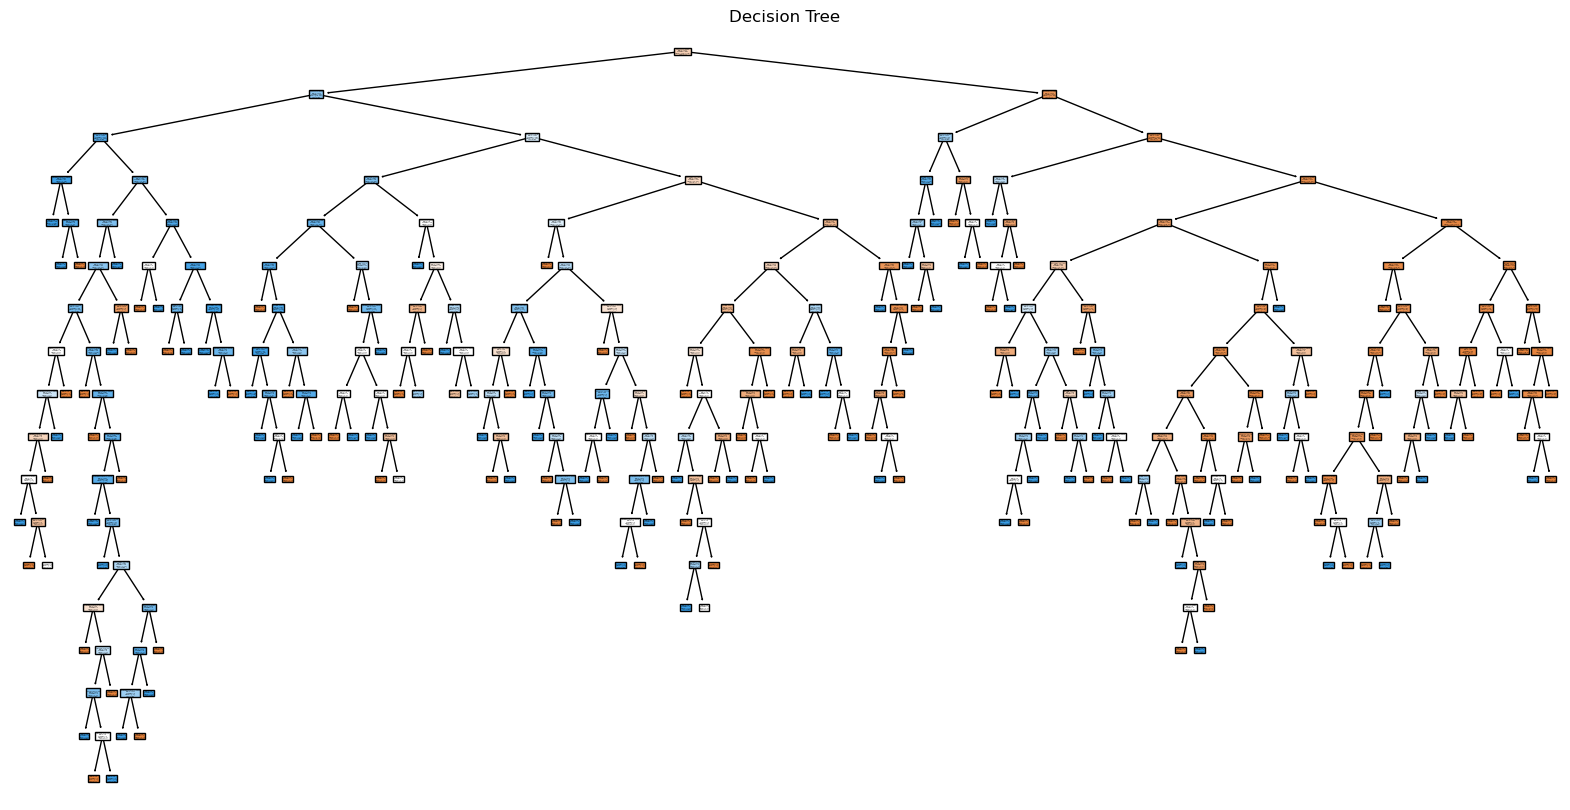

163

In [10]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=clf.classes_)
plt.title("Decision Tree")
plt.show()
n_terminal_nodes = clf.get_n_leaves()
n_terminal_nodes


# ## (d) Use export_text to summarize and interpret one node

In [11]:
from sklearn.tree import export_text

summary = export_text(clf, feature_names=list(X_train.columns))
print(summary)


|--- LoyalCH <= 0.50
|   |--- LoyalCH <= 0.28
|   |   |--- LoyalCH <= 0.06
|   |   |   |--- WeekofPurchase <= 268.50
|   |   |   |   |--- class: MM
|   |   |   |--- WeekofPurchase >  268.50
|   |   |   |   |--- SalePriceMM <= 2.15
|   |   |   |   |   |--- class: MM
|   |   |   |   |--- SalePriceMM >  2.15
|   |   |   |   |   |--- class: CH
|   |   |--- LoyalCH >  0.06
|   |   |   |--- LoyalCH <= 0.21
|   |   |   |   |--- WeekofPurchase <= 273.00
|   |   |   |   |   |--- WeekofPurchase <= 261.00
|   |   |   |   |   |   |--- PriceDiff <= -0.13
|   |   |   |   |   |   |   |--- SalePriceMM <= 1.64
|   |   |   |   |   |   |   |   |--- WeekofPurchase <= 236.50
|   |   |   |   |   |   |   |   |   |--- WeekofPurchase <= 234.00
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH <= 0.16
|   |   |   |   |   |   |   |   |   |   |   |--- class: MM
|   |   |   |   |   |   |   |   |   |   |--- LoyalCH >  0.16
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |

# ## (e) Predict on test data and produce confusion matrix

In [12]:
from sklearn.metrics import confusion_matrix

test_preds = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, test_preds)
test_error = 1 - accuracy_score(y_test, test_preds)
conf_matrix, test_error


(array([[122,  37],
        [ 41,  70]], dtype=int64),
 0.28888888888888886)

# ## (f) Use cross-validation to determine optimal tree size

In [13]:
from sklearn.model_selection import cross_val_score

path = clf.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

clfs = [DecisionTreeClassifier(random_state=42, ccp_alpha=alpha).fit(X_train, y_train) for alpha in alphas]
scores = [np.mean(cross_val_score(tree, X_train, y_train, cv=10)) for tree in clfs]


# ## (g) Plot tree size vs CV error rate

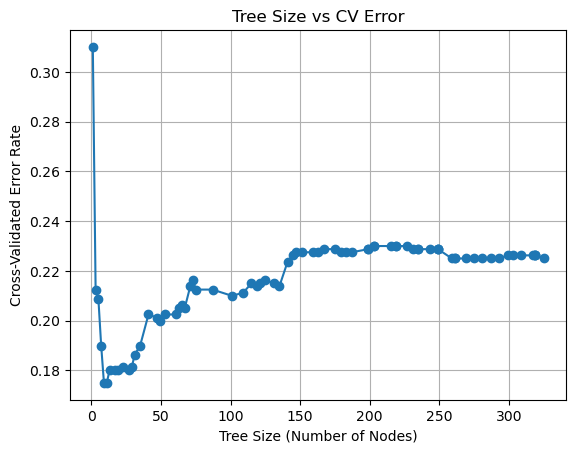

In [14]:
sizes = [tree.tree_.node_count for tree in clfs]
cv_errors = [1 - score for score in scores]

plt.figure()
plt.plot(sizes, cv_errors, marker='o')
plt.xlabel("Tree Size (Number of Nodes)")
plt.ylabel("Cross-Validated Error Rate")
plt.title("Tree Size vs CV Error")
plt.grid(True)
plt.show()

# ## (h) Tree size with lowest CV error

In [15]:
min_error_idx = np.argmin(cv_errors)
optimal_alpha = alphas[min_error_idx]
optimal_size = sizes[min_error_idx]
optimal_alpha, optimal_size


(0.006597346201628912, 11)

# ## (i) Prune tree using optimal alpha or create a 5-node tree

In [16]:
if optimal_alpha > 0:
    pruned_tree = DecisionTreeClassifier(random_state=42, ccp_alpha=optimal_alpha).fit(X_train, y_train)
else:
    pruned_tree = DecisionTreeClassifier(random_state=42, max_leaf_nodes=5).fit(X_train, y_train)


# ## (j) Compare training error of pruned vs unpruned tree

In [17]:
pruned_train_error = 1 - accuracy_score(y_train, pruned_tree.predict(X_train))
train_error, pruned_train_error


(0.007499999999999951, 0.15625)

# ## (k) Compare test error of pruned vs unpruned tree

In [18]:
pruned_test_error = 1 - accuracy_score(y_test, pruned_tree.predict(X_test))
test_error, pruned_test_error

(0.28888888888888886, 0.19259259259259254)